<a href="https://colab.research.google.com/github/aureliemai/lmapr1492/blob/main/LGBIO2060_Projet2_Gr25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project 2 : Hidden Markov models and optimal control
Authors : Simon Vandergooten and Clémence Vandamme.

In this second project, you will implement a Hidden Markov Model with 3 states and apply to your posterior probabilities optimal control. In other words, based on your knowledge and uncertainties, you will decide the optimal actions you need to take in any situation.

##Context :
The belgian government is trying to develop a new strategy to differentiate between patients with hypertension and those with hypotension in order to help preventing fainting and cardiac arrest.

Patients can be in one of the three following states : healthy, hypertension or hypotension. The patient's health status is represented by the vector $S$, where each value $s_t$ represents the patient's status in day $t$. The government also provides you the transition probabilities between each state, based on data from the national public health department.

You received the blood pressure measurements of a patient for 150 days. Those measurements are made with a new state-of-the-art tool. However, the design of this tool is not yet perfected and the measurements are for the moment very imprecise. Based on these data, you are asked to provide an estimate of the true state of the patient. 

Furthermore, two drugs are available on the market. One aims to lower the blood pressure, the other increases it. At each moment, you need to determine if you should take a drug and which one. However, take into account that these drugs have a cost and that taking a drug when healthy represents a risk to make the situation worse.  

##Practical information:
### HMM

The following graph sums up the different states and their transition probabilities. **The initial state is healthy**.

<img alt='Solution hint' align='center' width=413 height=300 src=https://raw.githubusercontent.com/svandergoote/LGBIO2060-2021/master/Solutions/Projet2_bis.png> 

\\

### Measurements

Concerning the measurements $m_t$, the systolic blood pressure levels are distributed as follow:

* $m_t \sim \mathcal{N}$(120, $\sigma_{healthy}^2$) if $s_t$ = 'healthy'.

* $m_t \sim \mathcal{N}$(160, $\sigma_{hyper}^2$) if $s_t$ = 'hyper'.

* $m_t \sim \mathcal{N}$(80, $\sigma_{hypo}^2$) if $s_t$ = 'hypo'.

Where $\sigma_{healthy}, \, \sigma_{hyper}, \, \sigma_{hypo}=27, \, 30\, , 28$  are the measurement noise related to the new tool.
 

\\
### Potential actions and their effects

Each day, you have 3 options:
- Take a drug A
    - It has 80% chances to **lower** your tension to 120 if you suffer from **hypertension**. (Therefore, 20% chances to have no effect). 
    - It has 40% chance to **lower** your tension to 80 if you were **healthy**. 
    - It has **no effect** if you suffer from **hypotension**.

- Take a drug B 
    - It has 80% chances to **increase** your tension to 120 if you suffer from **hypotension**.
    - It has 40% chances to **increase** your tension to 160 if you were **healthy**.
    - It has **no effect** if you suffer from **hypertension**.

- Do nothing: no effect on your blood pressure in any state. 

NOTE : The action has no impact on the state transition and the state itself. It should only be the most appropropriate action based on your belief about the state.

\\
### Utility and cost
Utility values associated to blood pressure: 
- 120 mmHg : U = +2
- 160 mmHg : U = -2 (risk of heart attack)
- 80 mmHg : U = -1 (risk of fainting) 

Costs:
- Drug A : 2
- Drug B : 2







## Guidelines 

**READ THIS PART CAREFULLY**

For the first part of the project, you are asked to estimate the posterior probability of each state at any time, based on the measurements vector M and on the transition probabilities. M contains 150 measurements. Then, graphically represent the evolution of these probabilities. The way you plot these data are up to you, make it readable and interpretable (you do not necessarily have to represent all the time step). 


In the second part, determine the policy you will follow at each time step to choose the optimal action. Based on this policy, return the vector of actions taken for the given data. A policy must be optimal in the sense that it maximizes the benefit (utility) and minimizes the cost. It simply consists in setting a threshold on your posterior belief. For example, "*if I have more than 65% probability to have hypertension, I will take drug A*" is a policy. We give you the 100 first true states to test different policies (i.e, different thresholds) and determine which one is the best. Indeed, with the true states, you can determine the impact of your actions and compute both the benefit and the cost. 
After finding your optimal policy, you can look at the actions chosen for your measures for which you do not have the true states (i.e the last 50 measurements).


Finally, discuss the impact of some relevant parameters of the model. For exemple, what do you observe in the policy and selected actions if the cost of both drugs increase ? 


\\
###To sum up:

1) Create your HMM and compute the posterior probabilities associated to each state based on the measurements. 

2) Graphically represent the evolution of the posteriors.

3) Define an optimal policy (this answer must appear clearly).  

4) Based on your policy, determine the drug to take at each time step for the given data. 

5) Discuss the impact of the parameters of the model on the policy and the resulting actions. 


###Data:

- The vector $S$ containing the 100 first hidden states $s_t$: 
  * $s_t$ = 'healthy' if the patient's state is healthy for day $t$ 
  * $s_t$ = 'hyper' if the patient's state is hypertension for day $t$ 
  * $s_t$ = 'hypo' if the patient's state is hypotension for day $t$ 

  It must be only used to determine the optimal policy. **It cannot be used for the HMM**. 

- The vector $M$ containing 150 measurements $m_t$. It is a vector of scalars. 

###Submission
Like for the first project, you must submit your notebook with all your answers. \\
The **deadline is the Thurday 25 November 23:59**. Name your notebook as follow : "LGBIO2060_Projet2_Grxx". \\
Don't forget to register for a timeslot for the oral evaluation.

In [70]:
#@title Imports

import numpy as np
import pandas as pd 
import io
import matplotlib.pyplot as plt
from scipy import stats
import ipywidgets as widgets

In [ ]:
#@title Files upload
from google.colab import files
uploaded = files.upload()

S = pd.read_csv(io.BytesIO(uploaded['S_training.csv'])).to_numpy()[:,1:]
M = pd.read_csv(io.BytesIO(uploaded['M.csv'])).to_numpy()[:,1:]

Saving M.csv to M (2).csv
Saving S_training.csv to S_training (2).csv


### 1) Create your HMM and compute the posterior probabilities associated to each state based on the measurements


In [ ]:
#@title 1.1 Calculate likelihood of seeing data `M` for all measurement models
def compute_likelihood(means, sigma, M):
  """ Calculate likelihood of seeing data `M` for all measurement models
  Returns:
    L (matrix): the likelihood
  """
  
  #Initialization of distribution
  p_healthy = stats.norm(loc = means[0], scale = sigma[0])
  p_hyper   = stats.norm(loc = means[1], scale = sigma[1])
  p_hypo    = stats.norm(loc = means[2], scale = sigma[2])


  #Extract the likelihood from pdf
  L = np.zeros(3)
  for i in range(len(M)):
    L[0] = np.array([p_healthy.pdf(M[i])])
    L[1] = np.array([p_hyper.pdf(M[i])])
    L[2] = np.array([p_hypo.pdf(M[i])])
  
  return L



In [ ]:
#@title 1.2 Given a HMM model, calculate the one-time-step updates to the posterior
def one_step_update(T, posterior_tm1, M_t, means, sigma):
  """ Given a HMM model, calculate the one-time-step updates to the posterior.
  Returns:
    prediction (numpy array): prediction at `t` (Today's prior)
    likelihood (numpy array): likelihood of seeing data M_t for all measurements models
    posterior_t (numpy array): Posterior at `t`
  """

  # Calculate predictive probabilities (prior)
  prediction = posterior_tm1.dot(T) #Multiplication du vecteur posterior_tm1 avec la matrice T

  #Get the likelihood (Hint: Use compute_likelihood)
  likelihood = compute_likelihood(means, sigma, M_t)

  #Calculate posterior
  posterior_t = prediction * likelihood

  #Normalize
  posterior_t /= np.sum(posterior_t)

  return prediction, likelihood, posterior_t

In [ ]:
#@title 1.3 Given the HMM model, calculate posterior marginal predictions of x_t for N-1 time steps ahead based on evidence data
def simulate_forward_inference(means, sigma, T, startProba, N, data):
  """
  Returns:
    predictive_probs (numpy array): predictive probabilities 
    likelihoods (numpy array): likelihood of seeing data M_t for all measurements models
    posterior_probs (numpy array): posterior probabilities 
  """
  
  #Initialize arrays
  predictive_probs = np.zeros((N,3))
  likelihoods = np.zeros((N,3))
  posterior_probs = np.zeros((N,3))

  #Calculate marginal for each latent state x_t

  #Start with the first element
  predictive_probs[0,:] = startProba
  likelihoods[0,:] = compute_likelihood(means, sigma, data[0])
  posterior = predictive_probs[0,:] * likelihoods[0,:]
  posterior_probs[0,:] = posterior / np.sum(posterior)

  #Then iterate for the rest of the N elements
  for t in range(1, N):
    predictive, likelihood, posterior = one_step_update(T, posterior_probs[t-1], data[t], means, sigma)
    predictive_probs[t] = predictive
    likelihoods[t] = likelihood
    posterior_probs[t] = posterior

  return predictive_probs, likelihoods, posterior_probs

In [ ]:
#@title 1.4 Set the parameters
T = np.array([[0.3, 0.4, 0.3], [0.25, 0.65, 0.1], [0.6, 0.1, 0.3]])
means = np.array([120, 160, 80])
sigma = np.array([27, 30, 28])
N = 150
startProba = np.array([1,0,0]) #The initial state is healthy
predictive_probs, likelihoods, posterior_probs = simulate_forward_inference(means, sigma, T, startProba, N, M)

### 2) Graphically represent the evolution of the posteriors

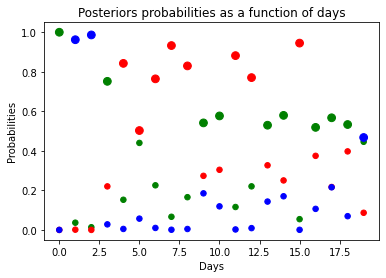

In [77]:
#@title 2.1 Representation of the posteriors as a function of time
prob_healthy = [p_vec[0] for p_vec in posterior_probs]
prob_hyper   = [p_vec[1] for p_vec in posterior_probs]
prob_hypo    = [p_vec[2] for p_vec in posterior_probs]

fig, ax = plt.subplots()
N_show = 20
mat=np.zeros((150,3))
states = np.empty(150, dtype=np.ndarray)

size_healthy=np.repeat(30,150)
size_hyper=np.repeat(30,150)
size_hypo=np.repeat(30,150)

for t in range(150):
  vec = prob_healthy[t], prob_hyper[t], prob_hypo[t]
  if vec[0] > vec[1] and vec[0] > vec[2]:
    size_healthy[t]=60
    mat[t][0] = prob_healthy[t]
    states[t] = 'healthy'
  if vec[1] > vec[0] and vec[1] > vec[2]:
    size_hyper[t]=60
    mat[t][1] = prob_hyper[t]
    states[t] = 'hyper'
  if vec[2] > vec[1] and vec[2] > vec[0]:
    size_hypo[t]=60
    mat[t][2] = prob_hypo[t]
    states[t] = 'hypo'

time=np.arange(N_show)
ax.scatter(time[:N_show],prob_healthy[:N_show], color="green",s=size_healthy[:N_show])    # RMQ faut encore plotter les days en int mais j'arrive pas 
ax.scatter(time[:N_show], prob_hyper[:N_show]  , color="red",s=size_hyper[:N_show])
ax.scatter(time[:N_show], prob_hypo[:N_show]   , color="blue",s=size_hypo[:N_show])

plt.xlabel('Days')   
plt.ylabel('Probabilities')
plt.title('Posteriors probabilities as a function of days')
plt.show(fig)

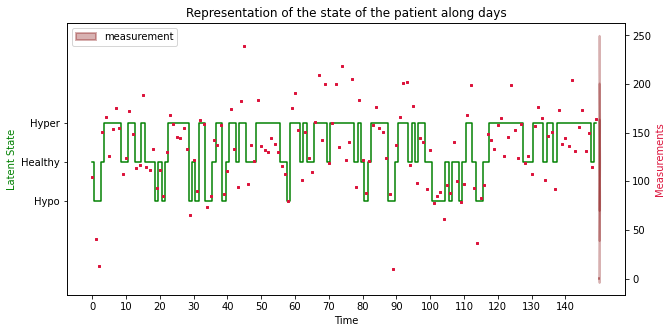

In [78]:
#@title 2.1 Representation of the states as a function of time
def plot_hmm1(noise_level, states, measurements, flag_m=True):
  """Plots HMM states and measurements for 1d states and measurements.

  Args:
    model (hmmlearn model):               hmmlearn model used to get state means.
    states (numpy array of floats):       Samples of the states.
    measurements (numpy array of floats): Samples of the states.
  """
  #Correction to avoid model
  means_vec = np.array([120., 160., 80.])
  n_components = 3
  vars_vec = np.ones(3) * noise_level * noise_level
  T = states.shape[0]
  nsteps = states.size
  aspect_ratio = 3
  fig, ax1 = plt.subplots(figsize=(10,5))
  #states_forplot = list(map(lambda s: means_vec[s], states))
  ax1.step(np.arange(nsteps), states, "-", where="mid", alpha=1.0, c="green")
  ax1.set_xlabel("Time")
  ax1.set_ylabel("Latent State", c="green")
  ax1.set_yticks([120, 160, 80])
  ax1.set_yticklabels(["Healthy", "Hyper", "Hypo"])
  ax1.set_xticks(np.arange(0,T,10))
  ymin = min(measurements)
  ymax = max(measurements)
  ax2 = ax1.twinx()
  ax2.set_ylabel("Measurements", c="crimson")

  # show measurement gaussian
  if flag_m:
    ax2.plot([T,T],ax2.get_ylim(), color="maroon", alpha=0.6)
    for i in range(n_components):
      mu = means_vec[i]
      scale = np.sqrt(vars_vec[i])
      rv = stats.norm(mu, scale)
      num_points = 50
      domain = np.linspace(mu-3*scale, mu+3*scale, num_points)
      left = np.repeat(float(T), num_points)
      # left = np.repeat(0.0, num_points)
      offset = rv.pdf(domain)
      offset *= T / 15
      lbl = "measurement" if i == 0 else ""
      # ax2.fill_betweenx(domain, left, left-offset, alpha=0.3, lw=2, color="maroon", label=lbl)
      ax2.fill_betweenx(domain, left+offset, left, alpha=0.3, lw=2, color="maroon", label=lbl)
      ax2.scatter(np.arange(nsteps), measurements, c="crimson", s=4)
      ax2.legend(loc="upper left")
    ax1.set_ylim(ax2.get_ylim())
  plt.title('Representation of the state of the patient along days')
  plt.show(fig)

tensions=np.zeros(len(states))
for i in range(len(states)):
  if states[i] == 'healthy':
    tensions[i] = 120
  if states[i] == 'hyper':
    tensions[i] = 160
  if states[i] == 'hypo':
    tensions[i] = 80

plot_hmm1(sigma, tensions, M, flag_m=True)

### 3) Define an optimal policy

### Explanation of our policy
To define our policy, we decided to optimize the action to do taking into account the utility after taking the drug (or not) and the cost. For each action (do nothing, take drug A, take drug B), we calculate what would be the utility after doing this action knowing that the drugs have a cost of 2 and that, in the case of the HMM model, the patient has a probability $p_0$ to be healthy, $p_1$ to be in hyper tension and $p_2$ to be in hypo tension. We know that the utility of being healthy is 2, the one of being in hyper tension is -2 and to be in hypo tension is a utility of -1.

We can see below a tree which helps us to calculate the impact of each action according to the patient's current state.

### An example using our policy
We will give an example in order to show our policy. Let's consider that the posteriors probabilities are $p_0 = 0.2$, $p_1 = 0.1$ and $p_2 = 0.7$. That means that the patient has a probability of 20% of being healthy, 10% of being in hyper tension and 70% of being in hypo tension.
In that case, the combination of the utility and the cost is -0.5 if the patient does nothing, -2.42 if the patient takes drug A and -1.14 if the patient takes drug B (see calculations below). As the impact of doing nothing is the highest, the patient will take drug B.

Calculations:

Do nothing: $p_0 * p(utility=2)*utility_{health} + p_1*p(utility=-2)*utility_{hyper} + p_2*p(utility=-1)*utility_{hypo}$

$= 0.2*1*2 + 0.1*1*(-2) + 0.7*1*(-1) = -0.5$

Take drug A: $p_0*(p(utility=-1)*utility_{hypo} + p(utility=2)*utility_{healthy}) + p_1*(p(utility=2)*utility_{healthy} + p(utility=-2)*utility_{hyper}) + p_2*p(utility=-1)*utility_{hypo} - costA$

$= 0.2*(0.4*(-1) + 0.6*2) + 0.1*(0.8*2 + 0.2*(-2)) + 0.7*1*(-1) - 2 = -2.42$

Take drug B: $p_0*(p(utility=-2)*utility_{hyper} + p(utility=2)*utility_{healthy}) + p_1*p(utility=-2)*utility_{hyper} + p_2*(p(utility=2)*utility_{healthy} + p(utility=-1)*utility_{hypo}) - costB$

$= 0.2*(0.4*(-2) + 0.6*2) + 0.1*1*(-2) + 0.7*(0.8*2 + 0.2*(-1)) - 2 = -1.14$

We could be challenged by the fact that the 3 values obtained are negative because it means that in all cases, whatever the patient does, the result of his action is negative. This is quite logical because the patient is ill, in our example he probably suffers from hypotension and is therefore in poor health and in our example the drugs are quite expensive.

In [ ]:
#Upload tree
from google.colab import files
from IPython.display import Image
uploaded = files.upload()

In [ ]:
#@title Policy tree
#Show tree
Image('Tree.JPG')

### 4) Based on your policy, determine the drug to take at each time step for the given data

In [ ]:
#@title

p3 = 1.0

utility_healthy = 2
utility_hypo = -1
utility_hyper = -2

def actions(costA, costB, states_proba,p1,p2,N):
  
  healthy = np.array([p3*utility_healthy, p1*utility_hypo+(1-p1)*utility_healthy-costA , p1*utility_hyper+(1-p1)*utility_healthy-costB])
  hypo    = np.array([p3*utility_hypo   , p3*utility_hypo-costA                        , p2*utility_healthy+(1-p2)*utility_hypo-costB ])
  hyper   = np.array([p3*utility_hyper  , p2*utility_healthy+(1-p2)*utility_hyper-costA, p3*utility_hyper-costB                       ])

  benefice = np.array([healthy, hyper, hypo])
  benef = states_proba.dot(benefice)

  actionToDo = ['']*N
  maximum = np.zeros(N)
  stat = np.zeros(3)
  
  for i in range(N):
    maximum = np.argmax(benef[i])

    if maximum == 0:
      stat[0] += 1
      actionToDo[i] = 'Do nothing'
    if maximum == 1:
      stat[1] += 1
      actionToDo[i] = 'Drug A'
    if maximum == 2:
      stat[2] += 1
      actionToDo[i] = 'Drug B'

  return actionToDo

In [ ]:
#@title
def get_count_states():
  count_states=np.zeros([3,3])

  for i in range(100):
    if S[i] == 'healthy':
      if states[i] == 'healthy':
        count_states[0][0] += 1
      if states[i] == 'hyper':
          count_states[0][1] += 1
      if states[i] == 'hypo':
        count_states[0][2] += 1

    if S[i] == 'hyper':
      if states[i] == 'healthy':
        count_states[1][0] += 1
      if states[i] == 'hyper':
        count_states[1][1] += 1
      if states[i] == 'hypo':
        count_states[1][2] += 1

    if S[i] == 'hypo':
      if states[i] == 'healthy':
        count_states[2][0] += 1
      if states[i] == 'hyper':
        count_states[2][1] += 1
      if states[i] == 'hypo':
        count_states[2][2] += 1

  sum_healthy=np.sum(count_states[0])
  sum_hyper=np.sum(count_states[1])
  sum_hypo=np.sum(count_states[2])

  print('Patient is healthy: \n Considered as healthy: {} \n Considered as hyper: {} \n Considered as hypo: {} \n'.format(count_states[0][0],count_states[0][1],count_states[0][2]))
  print('Patient is hyper: \n Considered as hyper: {} \n Considered as healthy: {} \n Considered as hypo: {} \n'.format(count_states[1][1],count_states[1][0],count_states[1][2]))
  print('Patient is hypo: \n Considered as hypo: {} \n Considered as healthy: {} \n Considered as hyper: {} \n'.format(count_states[2][2],count_states[2][0],count_states[2][1]))

In [ ]:
#@title
def get_count_actions(p1,p2,costA,costB):
  count = 0
  true_states = np.zeros((100,3))
  for i in range(100):
    if S[i] == 'healthy':
      true_states[i][0] = 1
    if S[i] == 'hyper':
      true_states[i][1] = 1
    if S[i] == 'hypo':
      true_states[i][2] = 1
    if S[i] == states[i]:
      count += 1
  #print(count/100)
  #print(true_states)

  act1=actions(costA=costA, costB=costB, states_proba=posterior_probs,p1=p1,p2=p2,N=100)
  act2=actions(costA=costA, costB=costB, states_proba=true_states,p1=p1,p2=p2,N=100)

  count=[0]*9

  for i in range(100):
    if act1[i] == 'Do nothing':
      if act2[i] == 'Do nothing':
        count[0] += 1
      if act2[i] == 'Drug A':
        count[1] += 1
      if act2[i] == 'Drug B':
        count[2] += 1

    if act1[i] == 'Drug A':
      if act2[i] == 'Drug A':
        count[3] += 1
      if act2[i] == 'Do nothing':
        count[4] += 1
      if act2[i] == 'Drug B':
        count[5] += 1

    if act1[i] == 'Drug B':
      if act2[i] == 'Drug B':
        count[6] += 1
      if act2[i] == 'Do nothing':
        count[7] += 1
      if act2[i] == 'Drug A':
        count[8] += 1


  print('Ok to do nothing: {}\nDo nothing instead of taking drug A: {}\nDo nothing instead of taking drug B: {} \n'.format(count[0],count[1],count[2]))
  print('Ok to take drug A: {}\nTake drug A instead of doing nothing: {}\nTake drug A instead of taking drug B: {} \n'.format(count[3],count[4],count[5]))
  print('Ok to take drug B: {}\nTake drug B instead of doing nothing: {}\nTake drug B instead of taking drug A: {} \n'.format(count[6],count[7],count[8]))


In [ ]:
@widgets.interact
def plot_samples_widget(p1=widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.4),p2=widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.8),costA=widgets.IntSlider(min=-3, max=5, step=1, value=2),costB=widgets.IntSlider(min=-3, max=5, step=1, value=2)):
  get_count_actions(p1,p2,costA,costB)

In [ ]:
def get_last():
  a=actions(costA=2, costB=2, states_proba=posterior_probs,p1=0.4,p2=0.8,N=150)
  print(a)

#get_last50()